In [1]:
import requests
import time
import pickle
import io
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import *  # be more specific
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import cross_val_score, train_test_split, KFold 
from geopy.geocoders import Nominatim
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn_pandas import DataFrameMapper
import scipy.stats as stats
from sklearn.feature_selection import RFE
import statsmodels.api as sm

## Load data

In [2]:
# Unpickle data  
with open('df3.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.shape

(1235, 47)

In [4]:
df.columns.to_list()

['property_id',
 'price',
 'guests',
 'bedrooms',
 'beds',
 'baths',
 'latitude',
 'longitude',
 'review_rate',
 'review_num',
 'property_type',
 'link',
 'price_log',
 'bedrooms_inc',
 'property_type_inc',
 'Entire apartment',
 'Entire guest suite',
 'Entire house',
 'Private room in apartment',
 'Private room in house',
 'coordinates',
 'address',
 'hood',
 'zip',
 'ballard',
 'beacon hill',
 'burien',
 'capitol hill',
 'central district',
 'delridge',
 'downtown',
 'fremont',
 'green lake',
 'lake city',
 'lake union',
 'magnolia',
 'north seattle',
 'northgate',
 'phinney ridge',
 'queen anne',
 'rainier valley',
 'shoreline',
 'south end',
 'tukwila',
 'university district',
 'west seattle',
 'white center']

## Additional data cleaning

In [5]:
# Remove NaN
df = df.dropna()
df.shape

(1235, 47)

In [6]:
# Remove > 4 values for the number of baths (`baths`)
df['baths'].value_counts()
df.loc[df['baths'] > 4] = np.nan
df.dropna(inplace=True)
df.shape

(1235, 47)

In [7]:
# Remove > 7 values for the number of beds (`baths`)
df['beds'].value_counts()
df.loc[df['beds'] > 7] = np.nan
# df1.loc[df['beds'] == 0] = np.nan
df.dropna(inplace=True)
df.shape

(1235, 47)

In [8]:
df['zip'].astype(int)

0       98136
1       98122
2       98121
3       98109
4       98108
        ...  
1310    98107
1311    98102
1312    98122
1313    98125
1314    98144
Name: zip, Length: 1235, dtype: int64

(array([624., 473.,  95.,  25.,   8.,   5.,   1.,   3.,   0.,   1.]),
 array([ 20. ,  87.9, 155.8, 223.7, 291.6, 359.5, 427.4, 495.3, 563.2,
        631.1, 699. ]),
 <a list of 10 Patch objects>)

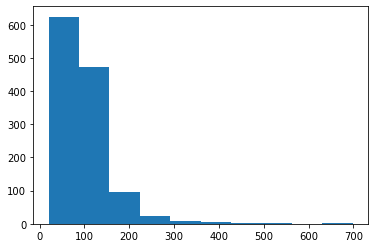

In [9]:
plt.hist(df['price'])

In [10]:
df.loc[df['price']>600, ['price']]

,price
1013,699.0


In [11]:
df.loc[df['price']>600, ['price']] = np.nan

## EDA

/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


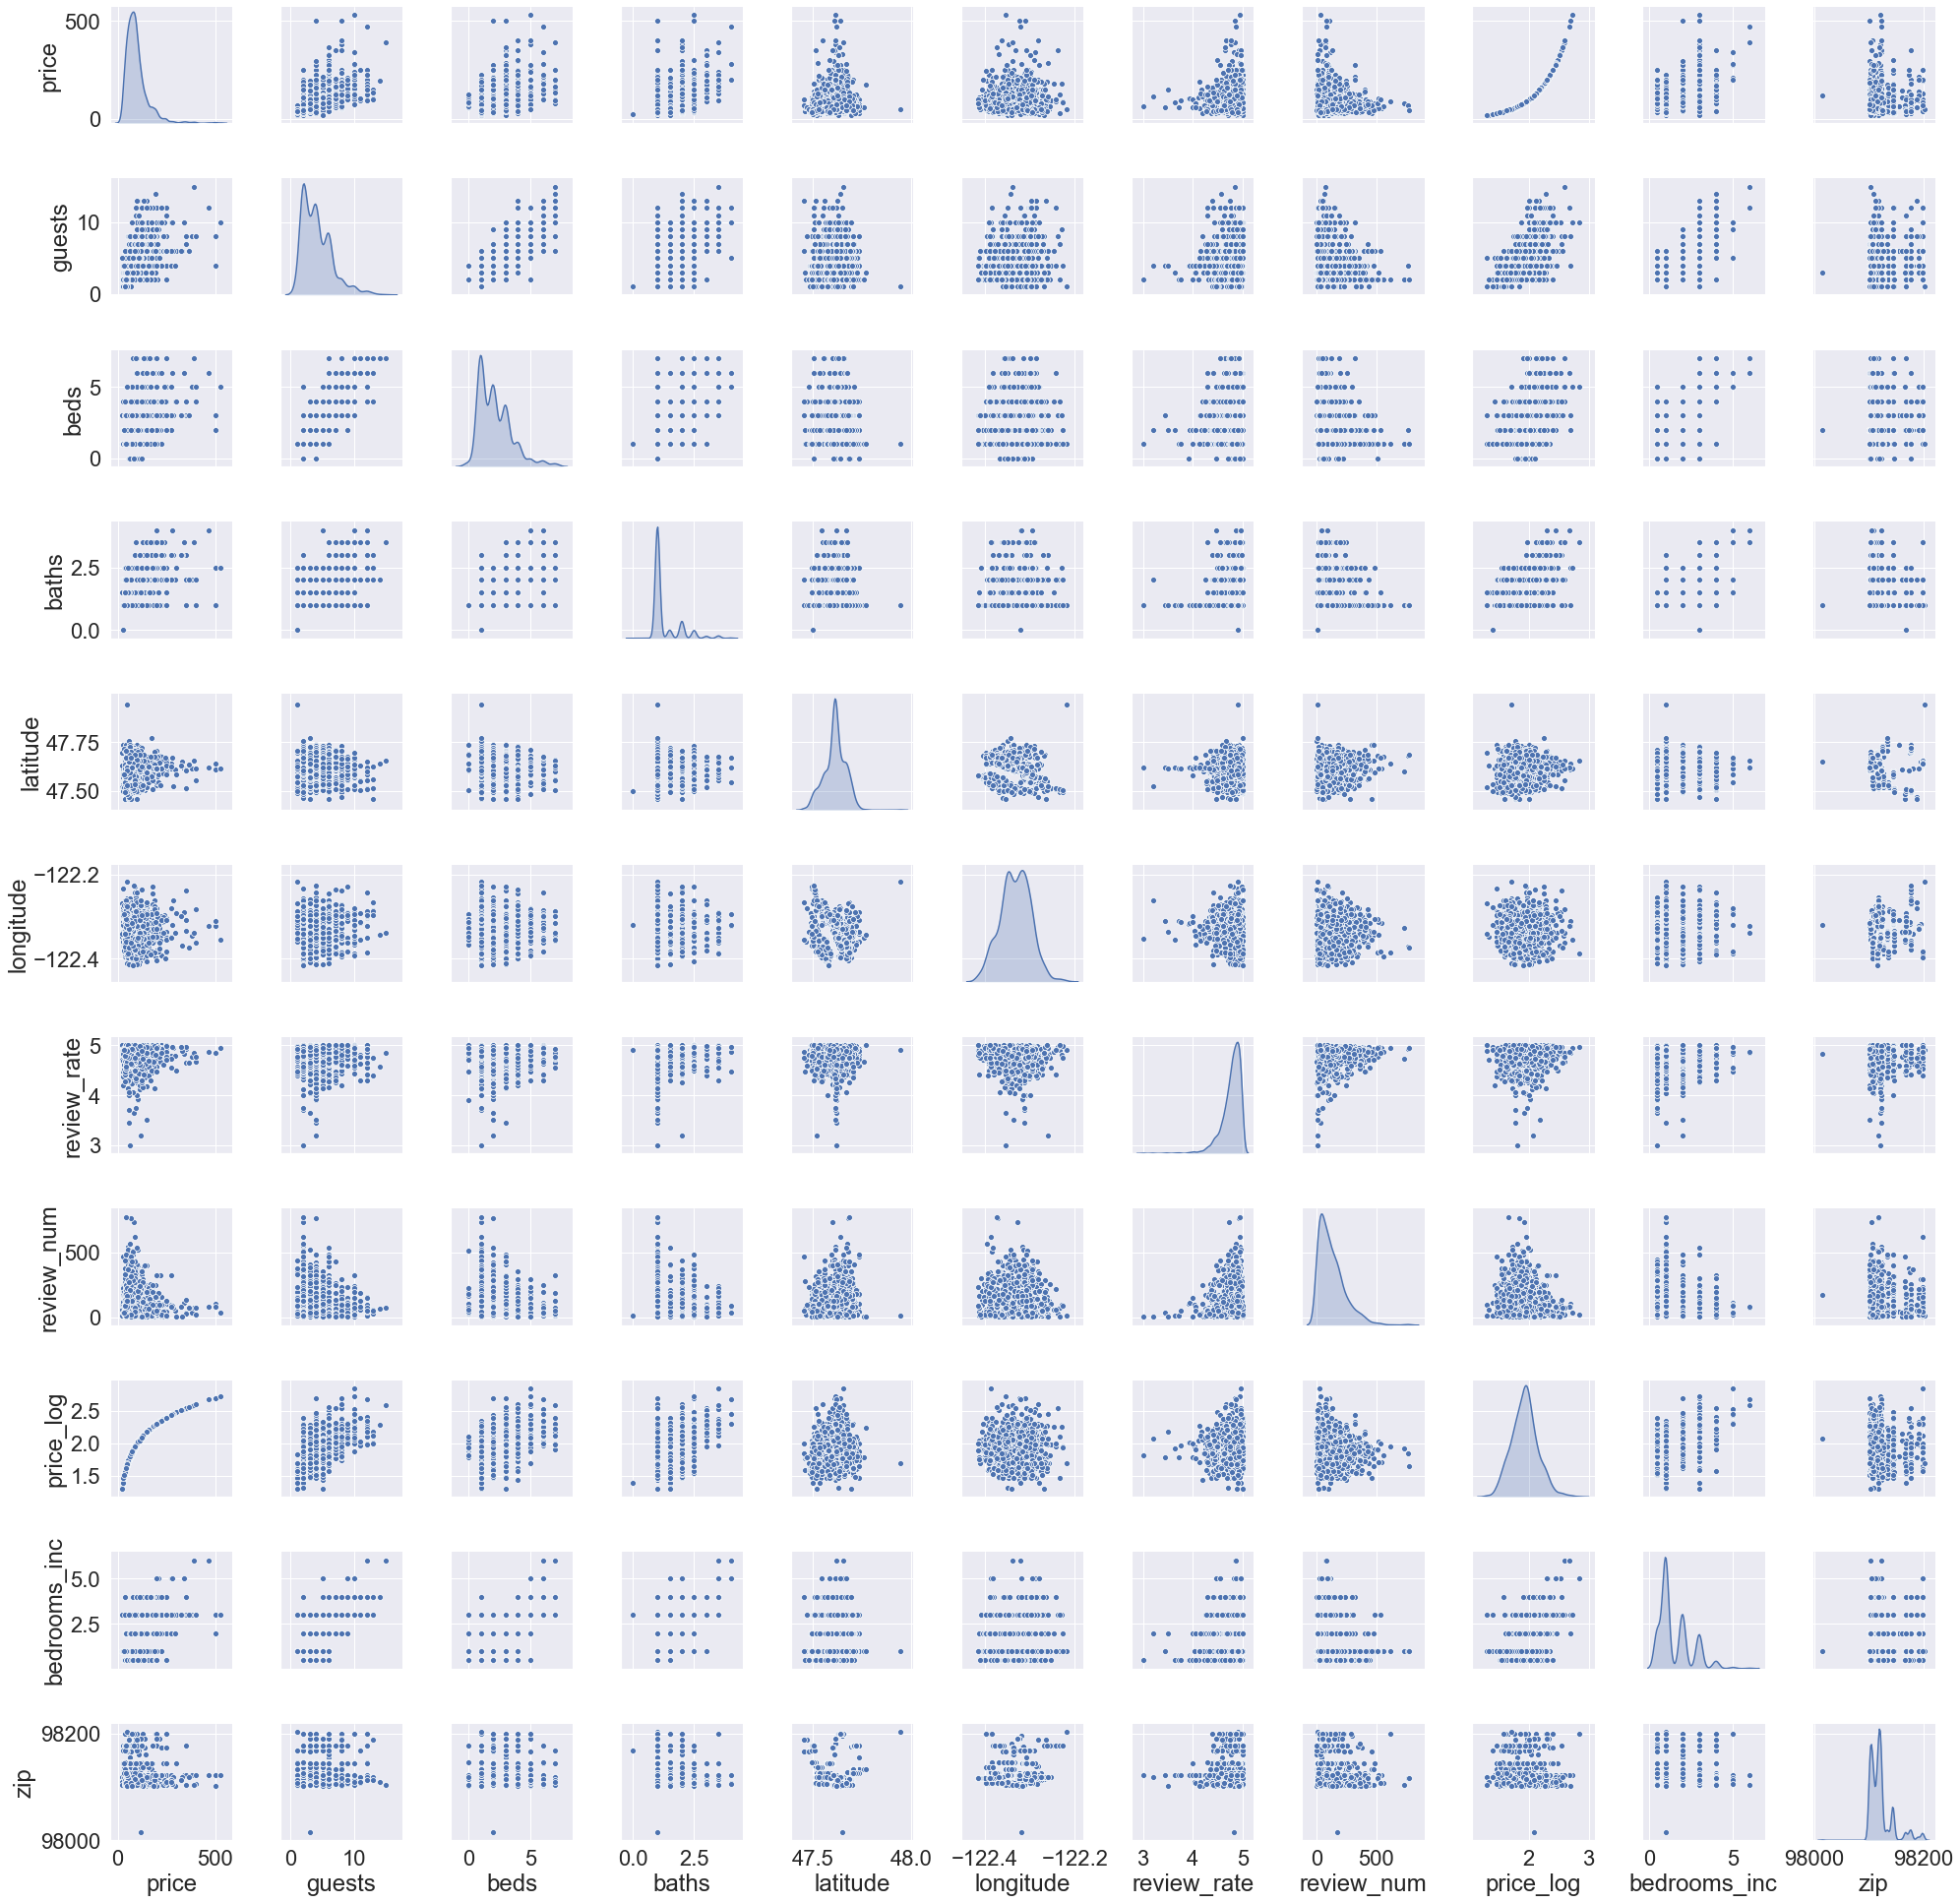

In [12]:
# Plot continuous variables 
sns.set(font_scale=2)
sns.pairplot(df.loc[:,
                 ['price', 'guests', 'beds', 'baths', 
                  'latitude', 'longitude', 'review_rate', 'review_num', 
                  'price_log', 'bedrooms_inc', 
                  'property_type_inc', 'zip']], 
             diag_kind='kde')
# plt.ylabel('y_test', fontsize=80)

In [13]:
# Candidates for power transformation (target has been transformed already): 
'zip', 'bedrooms_inc', 'review_num', 'review_rate', 'baths', 'beds', 'guests' 

('zip', 'bedrooms_inc', 'review_num', 'review_rate', 'baths', 'beds', 'guests')

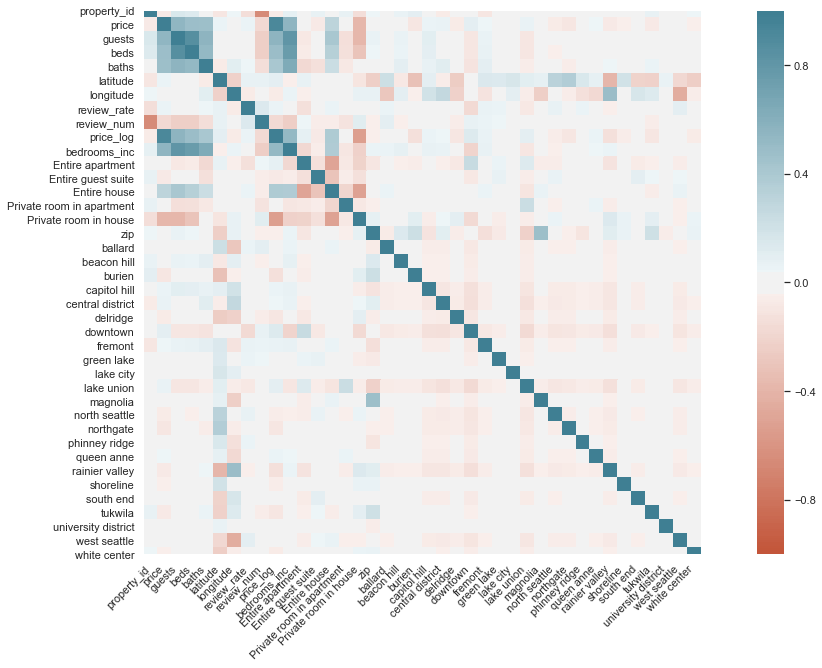

In [14]:
# Correlation matrix
sns.set(font_scale=1)
plt.subplots(figsize=(20,10))
hitmap = sns.heatmap(
    df.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
hitmap.set_xticklabels(
    hitmap.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


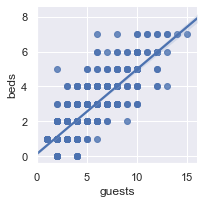

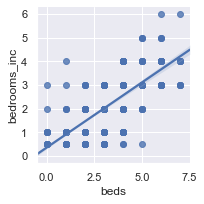

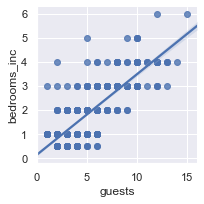

In [15]:
# Explore correlations between features
sns.set(font_scale=1)
sns.lmplot(x='guests', y='beds', data=df, size=3)
sns.lmplot(x='beds', y='bedrooms_inc', data=df, size=3)
sns.lmplot(x='guests', y='bedrooms_inc', data=df, size=3)

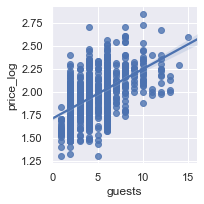

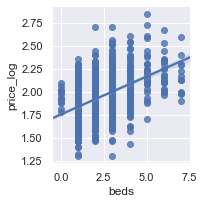

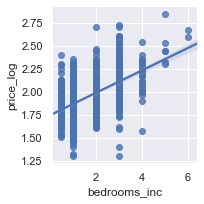

In [16]:
# Correlation between potentially correlated features and the target
sns.set(font_scale=1)
sns.lmplot(x='guests', y='price_log', data=df, size=3)
sns.lmplot(x='beds', y='price_log', data=df, size=3)
sns.lmplot(x='bedrooms_inc', y='price_log', data=df, size=3)

In [17]:
# Try taking out `beds` to decrease correlation between features. 
# Result: decreased R2 a bit. Keep these features.

## Linear Regression

In [18]:
# Set features and target
# Already removed redundant features, e.g `zip`, `latitude`, and `longitude`
X = df.loc[:, [
    'guests', 
    'baths', 
    'beds',
    'bedrooms_inc',
    'review_rate', 
    'review_num',
    'Entire apartment', 
    'Entire guest suite', 
    'Entire house',
    'Private room in apartment', 
    'Private room in house',
    'ballard', 'beacon hill', 'burien', 'capitol hill','central district', 'delridge', 'downtown', 'fremont', 
    'green lake','lake city', 'lake union', 'magnolia', 'north seattle', 'northgate','phinney ridge', 
    'queen anne', 'rainier valley', 'shoreline','south end', 'tukwila', 'university district', 'west seattle',
    'white center'
]]

y = df['price_log']

In [19]:
# Train and get model scores
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=10, shuffle=True)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)
    
# Train 
classifier = LinearRegression()
classifier.fit(X_train_scaled, y_train)
    
# R2 for train
R2_train = classifier.score(X_train_scaled, y_train)
print('R2 train: ', R2_train)

# Predict
y_pred = classifier.predict(X_test_scaled)
    
# R2 for test
R2_test = r2_score(y_test, y_pred)
print('R2 test: ', R2_test)
    
residuals = y_test - y_pred

R2 train:  0.586294392172598
R2 test:  0.5339798249000769


In [20]:
# Collect coefficients 

# Linear regression with no regularization
linreg_coef = classifier.coef_

# Ridge
classifier = RidgeCV(alphas=np.logspace(-2,3,100))
classifier.fit(X_train_scaled, y_train)
classifier.predict(X_test_scaled)
ridge_coef = classifier.coef_

In [21]:
# Errors
MAE_log = mean_absolute_error(y_test, y_pred)
MAE = math.pow(10, MAE_log)
print('Mean Absolute Error: ', MAE)

RMSE_log = mean_squared_error(y_test, y_pred)
RMSE = math.pow(10, RMSE_log)
print('Root Mean Square Error: ', RMSE)  

# Mean
y_mean_log = y.mean()
y_mean = np.power(10, y_mean_log)
math.pow(10, y_mean_log)
print('Mean:', y_mean)

Mean Absolute Error:  1.2827552394683157
Root Mean Square Error:  1.0485656345962528
Mean: 85.73592008770314


In [22]:
X.columns.to_list()

['guests',
 'baths',
 'beds',
 'bedrooms_inc',
 'review_rate',
 'review_num',
 'Entire apartment',
 'Entire guest suite',
 'Entire house',
 'Private room in apartment',
 'Private room in house',
 'ballard',
 'beacon hill',
 'burien',
 'capitol hill',
 'central district',
 'delridge',
 'downtown',
 'fremont',
 'green lake',
 'lake city',
 'lake union',
 'magnolia',
 'north seattle',
 'northgate',
 'phinney ridge',
 'queen anne',
 'rainier valley',
 'shoreline',
 'south end',
 'tukwila',
 'university district',
 'west seattle',
 'white center']

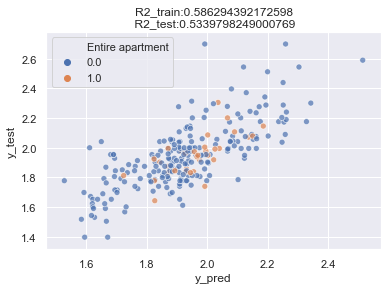

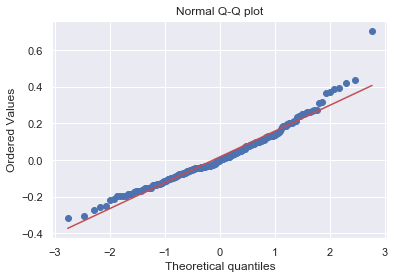

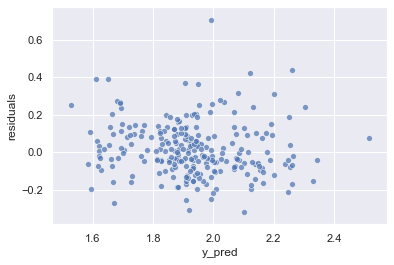

In [23]:
# Plot results and evaluations
fig = sns.scatterplot(x=y_pred, y=y_test, alpha=.7, data=X_test, hue='Entire apartment')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.title('R2_train:' + str(R2_train) + '\n R2_test:'+ str(R2_test))
# plt.savefig('mvp.svg') 
plt.show()
    
# QQ plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");
plt.show()

fig_x = sns.scatterplot(x=y_pred, y=residuals, alpha=.7)
plt.xlabel('y_pred')
plt.ylabel('residuals')
plt.title('')
# plt.savefig('mvp.svg') 
plt.show()

In [24]:
# Function: take out
def linearreg(X_, y_):
    '''
    Function trains linear regression (without regularization) on X and y passed in as arguments.
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2,random_state=10, shuffle=True)

    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train.values)
    X_test_scaled = scaler.transform(X_test.values)
    
    # Train 
    classifier = LinearRegression()
    classifier.fit(X_train_scaled, y_train)
    
    # R2 for train
    R2_train = classifier.score(X_train_scaled, y_train)
    print('R2 train: ', R2_train)

    # Predict
    y_pred = classifier.predict(X_test_scaled)
    
    # R2 for test
    R2_test = r2_score(y_test, y_pred)
    print('R2 test: ', R2_test)
    
    residuals = y_test - y_pred
    
    score_dict = {'R2_train':R2_train, 'R2_test':R2_test}
    return score_dict 

In [25]:
# Tried regularization (not shown) - no improvement of R2. Next - explore more complex models and 
# see if adding more observations would be beneficial.

## Would adding additional observations be beneficial?

In [26]:
# Assess whether more observations would be benefitial for improving the model
params = []
sample_size = []

for df_slice in range(100, 1200, 100):
    df_set = df.loc[:df_slice,:]
    
    sample_size.append(df_slice)
    
    X_set = df_set.loc[:, [
    'guests', 
    'baths', 
    'beds',
    'bedrooms_inc',
    'review_rate', 
    'review_num',
    'Entire apartment', 
    'Entire guest suite', 
    'Entire house',
    'Private room in apartment', 
    'Private room in house',
    'ballard', 'beacon hill', 'burien', 'capitol hill','central district', 'delridge', 'downtown', 'fremont', 
    'green lake','lake city', 'lake union', 'magnolia', 'north seattle', 'northgate','phinney ridge', 
    'queen anne', 'rainier valley', 'shoreline','south end', 'tukwila', 'university district', 'west seattle',
    'white center'
    ]]

    y_set = df_set['price_log']
    
    a = linearreg(X_set, y_set)
    params.append(a);

R2 train:  0.5773875965199282
R2 test:  0.060588215191787365
R2 train:  0.5505949846193355
R2 test:  -7.37364723791042e+26
R2 train:  0.5451396283829701
R2 test:  0.29921437212519264
R2 train:  0.5579106258845521
R2 test:  0.39170858376745965
R2 train:  0.5485294288915924
R2 test:  0.47927311721536936
R2 train:  0.552038323764215
R2 test:  -5.406399946449797e+20
R2 train:  0.5400743294572103
R2 test:  0.3634707635522578
R2 train:  0.5334264607728483
R2 test:  0.4350428746565286
R2 train:  0.5176026736981485
R2 test:  0.4576945325671732
R2 train:  0.5187010381109181
R2 test:  0.4785593916453582
R2 train:  0.5654043431196651
R2 test:  0.5345974030443256


In [27]:
# Arrange variables for plotting
R2_train_set = []
R2_test_set = []
for el in params:
     R2_train_set.append(el['R2_train'])
     R2_test_set.append(el['R2_test'])

R2_test_set = [x if x > 0 else np.nan for x in R2_test_set]

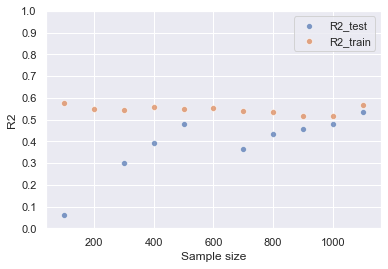

In [28]:
# Assess whether more observations would be benefitial for improving the model
sns.scatterplot(x=sample_size, y=R2_test_set, alpha=.7)
sns.scatterplot(x=sample_size, y=R2_train_set, alpha=.7)
plt.legend(('R2_test', 'R2_train'))
plt.xlabel('Sample size')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('R2')
plt.title('')
# plt.savefig('mvp.svg') 
plt.show()
# NB - replaced negative R2_test with 0

In [29]:
# Based on the R2 curves from test and train (above), adding more observations might not be the best use of time. 
# Look at increasing model complexity. 
# Adding more features is not time permitting at this point.

## Polinomial transformation to increase model complexity

In [30]:
# Feature transformation
scaler = StandardScaler()
tranformer = PolynomialFeatures(degree=2)
pipe = make_pipeline(tranformer, scaler)

X_train_scaled = pipe.fit_transform(X_train.values)
X_test_scaled = pipe.transform(X_test.values)

In [31]:
# Train 
classifier = LinearRegression()
classifier.fit(X_train_scaled, y_train)
# R2 for train
R2_train = classifier.score(X_train_scaled, y_train)
R2_train

0.7152401708573868

In [32]:
# Predict
y_pred = classifier.predict(X_test_scaled)
# R2 for test
R2_test = r2_score(y_test, y_pred)
R2_test

-1.3637810841315635e+24

In [33]:
# The model is overfitting train data that results in poor generalization. Explore regularization methods.

## Models with regularization

### Ridge

In [34]:
# Train 
classifier = RidgeCV(alphas=np.logspace(-2,3,100))
classifier.fit(X_train_scaled, y_train)
# R2 for train
R2_train = classifier.score(X_train_scaled, y_train)
R2_train

0.6407887344745224

In [35]:
# Predict
y_pred = classifier.predict(X_test_scaled)
# R2 for test
R2_test = r2_score(y_test, y_pred)
print(R2_test)

rigde_coef = classifier.coef_

0.528588790946519


In [36]:
# Ridge is performing better than a regression without regularization, still no improvement over the initial results.

### Lasso

In [37]:
# Train 
classifier = LassoCV(random_state=7, alphas=np.logspace(-2,3,100))
classifier.fit(X_train_scaled, y_train)
# R2 for train
R2_train = classifier.score(X_train_scaled, y_train)
R2_train

/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.5791582478460274

In [38]:
# Predict
y_pred = classifier.predict(X_test_scaled)
# R2 for test
R2_test = r2_score(y_test, y_pred)
R2_test

0.5218479631709922

In [39]:
# No improvement over the initial results.

### ElasticNet

In [40]:
# Train 
classifier = ElasticNetCV(random_state=7, alphas=np.logspace(-2,3,100))
classifier.fit(X_train_scaled, y_train)
# R2 for train
R2_train = classifier.score(X_train_scaled, y_train)
R2_train

/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.6142730489895758

In [41]:
# Predict
y_pred = classifier.predict(X_test_scaled)
# R2 for test
R2_test = r2_score(y_test, y_pred)
R2_test

0.524521638878924

In [42]:
# No improvement over the initial results.
# Overall, inclreasing the model complexity and subsequently using models with regularization 
# did not emprove the outcome.

 ## Power transformation to normalize features that have a scewed distribution

In [43]:
# Set features and target
X = df.loc[:,[      
    'guests', 
    'baths', 
    'beds',
    'bedrooms_inc',
    'review_rate', 
    'review_num',
    'Entire apartment', 
    'Entire guest suite', 
    'Entire house',
    'Private room in apartment', 
    'Private room in house',
    'ballard', 'beacon hill', 'burien', 'capitol hill','central district', 'delridge', 'downtown', 'fremont', 
    'green lake','lake city', 'lake union', 'magnolia', 'north seattle', 'northgate','phinney ridge', 
    'queen anne', 'rainier valley', 'shoreline','south end', 'tukwila', 'university district', 'west seattle',
    'white center'
]]

y = df['price_log']

In [44]:
# Feature transformation
scaler = StandardScaler()

power_transform = make_pipeline(PowerTransformer(), StandardScaler())

mapper = DataFrameMapper([
    (['review_num', 'review_rate', 'guests'], power_transform),
    (['baths', 'bedrooms_inc','beds', 
    'Entire apartment', 
    'Entire guest suite', 
    'Entire house',
    'Private room in apartment', 
    'Private room in house',
    'ballard', 'beacon hill', 'burien', 'capitol hill','central district', 'delridge', 'downtown', 'fremont', 
    'green lake','lake city', 'lake union', 'magnolia', 'north seattle', 'northgate','phinney ridge', 
    'queen anne', 'rainier valley', 'shoreline','south end', 'tukwila', 'university district', 'west seattle',
    'white center'], scaler)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=10, shuffle=True)

# mapper.fit_transform(X)

In [45]:
pipe = make_pipeline(mapper, LinearRegression())
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [46]:
R2_train = pipe.score(X_train, y_train)
R2_train

0.5916504771902213

In [47]:
R2_test = r2_score(y_test, y_pred)
R2_test

0.5446921197296899

In [48]:
# Slightely better R2 for the test than linear regression without power transformation

## Polinomial tranformation of  selected features

In [49]:
# Feature transformation
scaler = StandardScaler()
poli_transform = make_pipeline(PolynomialFeatures(degree=2), StandardScaler())

mapper = DataFrameMapper([
    (['review_num','review_rate','guests'], power_transform),
    (['guests', 'baths', 'bedrooms_inc','beds', 
    'Entire apartment', 
    'Entire guest suite', 
    'Entire house',
    'Private room in apartment', 
    'Private room in house',
    'ballard', 'beacon hill', 'burien', 'capitol hill','central district', 'delridge', 'downtown', 'fremont', 
    'green lake','lake city', 'lake union', 'magnolia', 'north seattle', 'northgate','phinney ridge', 
    'queen anne', 'rainier valley', 'shoreline','south end', 'tukwila', 'university district', 'west seattle',
    'white center'], scaler)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=10, shuffle=True)

# mapper.fit_transform(X)

In [50]:
pipe = make_pipeline(mapper, LassoCV())
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [51]:
R2_train = pipe.score(X_train, y_train)
R2_train

0.5884579941800967

In [52]:
R2_test = r2_score(y_test, y_pred)
R2_test

0.547499732863233

In [53]:
# Not a significant improvement of R2 score but is the best model trained so far. See linear regression
# with no feature manipulation with R2 = 0.5339798249000769.

## Feature interpretation

In [54]:
# Set features and target
X = df.loc[:,[      
    'guests', 
    'baths', 
    'beds',
    'bedrooms_inc',
    'review_rate', 
    'review_num',
    'Entire apartment', 
    'Entire guest suite', 
    'Entire house',
    'Private room in apartment', 
    'Private room in house',
    'ballard', 'beacon hill', 'burien', 'capitol hill','central district', 'delridge', 'downtown', 'fremont', 
    'green lake','lake city', 'lake union', 'magnolia', 'north seattle', 'northgate','phinney ridge', 
    'queen anne', 'rainier valley', 'shoreline','south end', 'tukwila', 'university district', 'west seattle',
    'white center'
]]

y = df['price_log']

In [55]:
# Fit model
model = sm.OLS(y, X, data=df)

results = model.fit()

# Model summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     51.86
Date:                Thu, 10 Oct 2019   Prob (F-statistic):          5.19e-201
Time:                        11:22:39   Log-Likelihood:                 656.37
No. Observations:                1235   AIC:                            -1247.
Df Residuals:                    1202   BIC:                            -1078.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
guests                        0.0126      0.004      2.919      0.004       0.004       0.021
baths                         0.0636      0.010      6.515      0.000       0.044       0.083
beds                         -0.0008      0.006     -0.118      0.906      -0.013       0.012
bedrooms_inc                  0.0616      0.008      7.255      0.000       0.045       0.078
review_rate                   0.1193      0.021      5.670      0.000       0.078       0.161
review_num                -8.899e-05   4.04e-05     -2.200      0.028      -0.000   -9.63e-06
Entire apartment              0.9734      0.083     11.743      0.000       0.811       1.136
Entire guest suite            0.9119      0.084     10.832      0.000       0.747       1.077
Entire house                  0.9579      0.084     11.469      0.000       0.794       1.122
Private room in apartment     0.9128      0.088     10.378      0.000       0.740       1.085
Private room in house         0.7509      0.083      9.019      0.000       0.588       0.914
ballard                       0.2173      0.030      7.305      0.000       0.159       0.276
beacon hill                   0.2075      0.032      6.393      0.000       0.144       0.271
burien                        0.0820      0.034      2.411      0.016       0.015       0.149
capitol hill                  0.2152      0.023      9.189      0.000       0.169       0.261
central district              0.2388      0.023     10.529      0.000       0.194       0.283
delridge                      0.1634      0.027      6.105      0.000       0.111       0.216
downtown                      0.3070      0.020     15.471      0.000       0.268       0.346
fremont                       0.2308      0.029      7.843      0.000       0.173       0.289
green lake                    0.1864      0.039      4.805      0.000       0.110       0.262
lake city                     0.1655      0.053      3.121      0.002       0.061       0.270
lake union                    0.3008      0.021     14.462      0.000       0.260       0.342
magnolia                      0.2617      0.036      7.326      0.000       0.192       0.332
north seattle                 0.2061      0.026      8.004      0.000       0.156       0.257
northgate                     0.1346      0.026      5.132      0.000       0.083       0.186
phinney ridge                 0.1736      0.034      5.065      0.000       0.106       0.241
queen anne                    0.2743      0.029      9.342      0.000       0.217       0.332
rainier valley                0.1554      0.022      6.977      0.000       0.112       0.199
shoreline                     0.1407      0.053      2.678      0.008       0.038       0.244
south end                     0.1857      0.031      6.062      0.000      

In [56]:
# Features
X = df.loc[:,[      
    'guests', 
    'baths', 
    'beds',
    'bedrooms_inc',
    'review_rate', 
    'review_num',
    'Entire apartment', 
    'Entire guest suite', 
    'Entire house',
    'Private room in apartment', 
    'Private room in house',
    'ballard', 'beacon hill', 'burien', 'capitol hill','central district', 'delridge', 'downtown', 'fremont', 
    'green lake','lake city', 'lake union', 'magnolia', 'north seattle', 'northgate','phinney ridge', 
    'queen anne', 'rainier valley', 'shoreline','south end', 'tukwila', 'university district', 'west seattle',
    'white center'
]]

y = df['price_log']

In [57]:
# Feature evaluation with Recirsive Feature Elimination
classifier = LinearRegression(normalize=True)
selector = RFE(classifier, step=1)
results = selector.fit(X, y)
support = results.support_
rank = results.ranking_
features = results.n_features_

In [58]:
# Pull together feature coefficients  and ranks
df_features = pd.DataFrame
df_features = pd.DataFrame(X.columns, columns=['features'])
df_features['rank'] = pd.DataFrame(rank)
df_features['support'] = pd.DataFrame(support) 
df_features['linreg_coef'] = pd.DataFrame(linreg_coef)
df_features['rigde_coef'] = pd.DataFrame(rigde_coef)

In [59]:
df_features

,features,rank,support,linreg_coef,rigde_coef
0,guests,16,False,2.779264e-02,0.000000
1,baths,15,False,3.652953e-02,0.007475
2,beds,17,False,5.081907e-03,0.007819
3,bedrooms_inc,14,False,5.420209e-02,0.004285
4,review_rate,13,False,2.583990e-02,0.009548
5,review_num,18,False,-8.314869e-03,0.008055
6,Entire apartment,1,True,1.199954e+11,-0.001290
7,Entire guest suite,1,True,7.728563e+10,0.002636
8,Entire house,1,True,1.541554e+11,0.000568
9,Private room in apartment,1,True,5.136603e+10,0.005270


In [60]:
# Selected features to list
df_sel_features = df_features.loc[df_features['support'], ['features']]
sel_features = list(df_sel_features['features'])

In [61]:
new_features = sel_features + ['guests', 'beds', 'bedrooms_inc', 'review_rate', 'baths']

In [62]:
# Combine `Private room in apartment` and `Private room in house` in `private_room` feature 
df['private_room'] = df['Private room in apartment'] + df['Private room in house']

new_features.append('private_room')
new_features.remove('Private room in apartment')
new_features.remove('Private room in house')

In [63]:
# Combine `Entire house` and `Entire apartment` in `entire_place` feature 
df['entire_place'] = df['Entire house'] + df['Entire apartment']

new_features.append('entire_place')
new_features.remove('Entire house')
new_features.remove('Entire apartment')

In [64]:
# Set features and target
X = df.loc[:, new_features]

y = df['price_log']

In [65]:
# Train linear regression with new_features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=10, shuffle=True)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)
    
# Train 
a = classifier = LinearRegression()
classifier.fit(X_train_scaled, y_train)
    
# R2 for train
R2_train = classifier.score(X_train_scaled, y_train)
print('R2 train: ', R2_train)

# Predict
y_pred = classifier.predict(X_test_scaled)
    
# R2 for test
R2_test = r2_score(y_test, y_pred)
print('R2 test: ', R2_test)
    
residuals = y_test - y_pred

linreg_coef = classifier.coef_

R2 train:  0.5593814731579054
R2 test:  0.5275303041844425


In [66]:
# R2 did not change much after reducing 34 features to 20.